# Deep Learning - Assigment 1

### Group Number: 22

### Teammates:
1. **Mahshid Jafar Tajrishi**
2. **Bar Melinarskiy**
3. **Cis van Aken**
4. **Simon van Klompenburg**

## Imports entire notebook

In [39]:
!pip install optuna

In [40]:
# Importing libraries
import pandas as pd
import numpy as np
from scipy.io import loadmat
from IPython.display import display
import torch
import torch.nn as nn
import torch.optim as optim
import optuna
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchsummary import summary
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
torch.autograd.set_detect_anomaly(True)
from copy import deepcopy as dc
import random
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
import json
from scipy.interpolate import interp1d
from google.colab import files

## Global Definitions

In [41]:
# Path to the zip file
#data_dir = "./Data"
#data_path = f"{data_dir}/Xtrain.mat"
mat_data = files.upload()
data = loadmat('Xtrain.mat')

# Set the device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set pandas display options to show all columns
pd.set_option('display.max_columns', None)

# Set a professional style for the plots
sns.set_theme(style="whitegrid")

Saving Xtrain.mat to Xtrain (3).mat


In [42]:
# Check if CUDA is available
print(torch.__version__)
print(torch.version.cuda)  # Should match CUDA 12.5
print(torch.backends.cudnn.version())  # Should return a version, not None
print(torch.cuda.is_available())  # Should return True

2.6.0+cu124
12.4
90300
True


### Utilities

In [43]:
def create_sequences(data, window_size, forecast_steps=1):
    X, y = [], []
    for i in range(len(data) - window_size - forecast_steps + 1):
        X.append(data[i:i + window_size, 0])
        y.append(data[i + window_size:i + window_size + forecast_steps, 0])
    X = np.array(X).reshape(-1, window_size, 1)
    y = np.array(y).reshape(-1, forecast_steps)
    return X, y

def prepare_dataloader(series, window_size, batch_size=16):
    """
    Preprocess the datasets for the transformer model.

    Args:
        series: Array of numbers with the sequence of the laser measurements.
        window_size: Integer, the sliding window size.
        batch_size: The number of samples used in one forward and backward pass through the network.

    Returns:
        DataLoader, X, y
    """
    X, y = create_sequences(series, window_size)
    # Ensure proper shapes: X → (N, seq_len, input_dim), y → (N, input_dim)
    X_tensor = torch.tensor(X, dtype=torch.float32)  # Shape: (N, seq_len, input_dim)
    y_tensor = torch.tensor(y, dtype=torch.float32)  # Shape: (N, input_dim)
    dataset = TensorDataset(X_tensor, y_tensor)
    return DataLoader(dataset, batch_size=batch_size, shuffle=False), X_tensor, y_tensor

def train_model(model, train_loader, val_loader, attempt_index, epochs=20, lr=1e-3, teacher_forcing_prob=0.5, patience=25):
    """
    Train the given model with validation and return the final validation L1 loss.
    Includes early stopping based on validation loss.
    Logs all metrics (L1, MSE, MAE) for each epoch into a DataFrame.
    """
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
    # Define loss functions
    huberLoss_criterion = nn.HuberLoss()  # Huber Loss
    mse_criterion = nn.MSELoss()  # MSE Loss
    mae_criterion = nn.L1Loss()  # MAE Loss (same as L1 Loss)

    best_val_loss = float('inf')
    best_model_state = model.state_dict()  # Initialize with the current model state
    no_improvement_epochs = 0  # Counter for early stopping

    # DataFrame to store metrics
    metrics_df = pd.DataFrame(columns=["trial_id", "epoch", "train_l1", "train_mse", "train_mae", "val_l1", "val_mse", "val_mae"])

    # Progress bar for epochs
    epochs_pbar = tqdm(range(epochs), desc=f"Trial: {attempt_index}", unit="epoch")

    for epoch in epochs_pbar:
        # Training phase
        model.train()
        running_train_huberLoss_loss = 0.0
        running_train_mse_loss = 0.0
        running_train_mae_loss = 0.0

        for batch_index, batch in enumerate(train_loader):
            x_batch, y_batch = batch[0].to(device), batch[1].to(device)

            # Forward pass
            output = model(x_batch)

            # Apply teacher forcing
            if random.random() < teacher_forcing_prob:
                x_batch = x_batch.clone()  # Avoid in-place modification
                x_batch[:, -1, 0] = y_batch[:, 0]

            # Calculate loss
            huberLoss_loss = huberLoss_criterion(output, y_batch)
            mse_loss = mse_criterion(output, y_batch)
            mae_loss = mae_criterion(output, y_batch)

            running_train_huberLoss_loss += huberLoss_loss.item()
            running_train_mse_loss += mse_loss.item()
            running_train_mae_loss += mae_loss.item()

            # Backward pass
            optimizer.zero_grad()
            mae_loss.backward()
            optimizer.step()

        avg_train_huberLoss_loss = running_train_huberLoss_loss / len(train_loader)
        avg_train_mse_loss = running_train_mse_loss / len(train_loader)
        avg_train_mae_loss = running_train_mae_loss / len(train_loader)

        # Validation phase
        model.eval()
        running_val_huberLoss_loss = 0.0
        running_val_mse_loss = 0.0
        running_val_mae_loss = 0.0

        with torch.no_grad():
            for batch in val_loader:
                x_batch, y_batch = batch[0].to(device), batch[1].to(device)
                output = model(x_batch)

                huberLoss_loss = huberLoss_criterion(output, y_batch)
                mse_loss = mse_criterion(output, y_batch)
                mae_loss = mae_criterion(output, y_batch)

                running_val_huberLoss_loss += huberLoss_loss.item()
                running_val_mse_loss += mse_loss.item()
                running_val_mae_loss += mae_loss.item()

        avg_val_huberLoss_loss = running_val_huberLoss_loss / len(val_loader)
        avg_val_mse_loss = running_val_mse_loss / len(val_loader)
        avg_val_mae_loss = running_val_mae_loss / len(val_loader)

        # Save metrics to DataFrame
        new_row = pd.DataFrame([{
            "trial_id": attempt_index,
            "epoch": epoch + 1,
            "train_HuberLoss": avg_train_huberLoss_loss,
            "train_MSE": avg_train_mse_loss,
            "train_MAE": avg_train_mae_loss,
            "val_HuberLoss": avg_val_huberLoss_loss,
            "val_MSE": avg_val_mse_loss,
            "val_MAE": avg_val_mae_loss
        }])
        metrics_df = pd.concat([metrics_df, new_row], ignore_index=True)

        # Save the best model
        if avg_val_mae_loss < best_val_loss:
            best_val_loss = avg_val_mae_loss
            best_model_state = model.state_dict()
            no_improvement_epochs = 0  # Reset early stopping counter
        else:
            no_improvement_epochs += 1  # Increment early stopping counter

        # Early stopping
        if no_improvement_epochs >= patience:
            print(f"Early stopping triggered after {epoch + 1} epochs.")
            break

        # Adjust learning rate
        scheduler.step()

        # Update progress bar
        epochs_pbar.set_postfix(
            Train_huberLoss_Loss=avg_train_huberLoss_loss,
            Train_MSE_Loss=avg_train_mse_loss,
            Train_MAE_Loss=avg_train_mae_loss,
            Val_huberLoss_Loss=avg_val_huberLoss_loss,
            Val_MSE_Loss=avg_val_mse_loss,
            Val_MAE_Loss=avg_val_mae_loss,
        )

    # Load the best model
    model.load_state_dict(best_model_state)

    return best_val_loss, metrics_df  # Return the best validation L1 loss and metrics DataFrame

### Simple RNN Model

In [44]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

'''class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers, dropout=0.0) :
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers,
                            batch_first=True, dropout=dropout if num_stacked_layers > 1 else 0.0)

        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out'''

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers, dropout=0.0) :
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.rnn = nn.RNN(input_size, hidden_size, num_stacked_layers,
                            batch_first=True, dropout=dropout if num_stacked_layers > 1 else 0.0)

        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        #c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)

        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out

### Load and Split the dataset into train-validation

In [45]:
# Define augmentation functions
def add_noise(x, std=0.05):
    return x + np.random.normal(0, std, size=x.shape)

def add_drift(x, strength=0.05):
    drift = np.linspace(0, strength, num=len(x)).reshape(-1, 1)
    return x + drift

def time_warp(x, stretch_factor=1.15):
    original_steps = np.arange(len(x))
    new_steps = np.linspace(0, len(x) - 1, int(len(x) * stretch_factor))
    warped = interp1d(original_steps, x.ravel(), kind='linear', fill_value="extrapolate")(new_steps)
    warped = warped[:len(x)]  # clip/pad to original size
    return warped.reshape(-1, 1)

# Define jittering function
def add_jitter(x, std=0.01):
    """
    Add small random perturbations (jitter) to the data.

    Args:
        x (np.ndarray): Input data.
        std (float): Standard deviation of the jitter.

    Returns:
        np.ndarray: Jittered data.
    """
    return x + np.random.normal(0, std, size=x.shape)


measurements = data['Xtrain']
# Check the shape of the data
print("Shape of measurements:", measurements.shape)

# Display the first few rows of the data
print(f"First 5 measurements: {measurements[:5]}")

print(f"measurements range: min={measurements.min()}, max={measurements.max()}")

# Creating sequences
max_window_size = 50  # Maximum window size
# Split data into training and validation sets
size_of_test = 200 + max_window_size  # 200 steps for testing + window size
train_data, val_data = measurements[:-size_of_test], measurements[-size_of_test:]

# Normalize the training data
scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(train_data)

# Normalize the validation data using the same scaler
val_data_normalized = scaler.transform(val_data)

# Augment training data
print(f"Train shape before augmention: {train_data.shape}")

augmented = [train_data]  # 1x original

for _ in range(2):  # 2x noise
    augmented.append(add_noise(train_data))

# for _ in range(2):  # 2x drift
#     augmented.append(add_drift(train_data))

# for _ in range(2):  # 2x time warp
#     augmented.append(time_warp(train_data))

for _ in range(2):  # 2x jittering
    augmented.append(add_jitter(train_data))

train_augmented = np.vstack(augmented)
print("Augmented shape:", train_augmented.shape)

# Creating sequences
train_dataset, val_dataset = train_augmented, val_data_normalized

print(f"Train shape: {train_dataset.shape}, Val shape: {val_dataset.shape}")
print(f"train_dataset range: min={train_dataset.min()}, max={train_dataset.max()}")
print(f"val_dataset range: min={val_dataset.min()}, max={val_dataset.max()}")

Shape of measurements: (1000, 1)
First 5 measurements: [[ 86]
 [141]
 [ 95]
 [ 41]
 [ 22]]
measurements range: min=2, max=255
Train shape before augmention: (750, 1)
Augmented shape: (3750, 1)
Train shape: (3750, 1), Val shape: (250, 1)
train_dataset range: min=1.9443709851170103, max=255.05074587182094
val_dataset range: min=-0.9209486166007904, max=0.3992094861660078


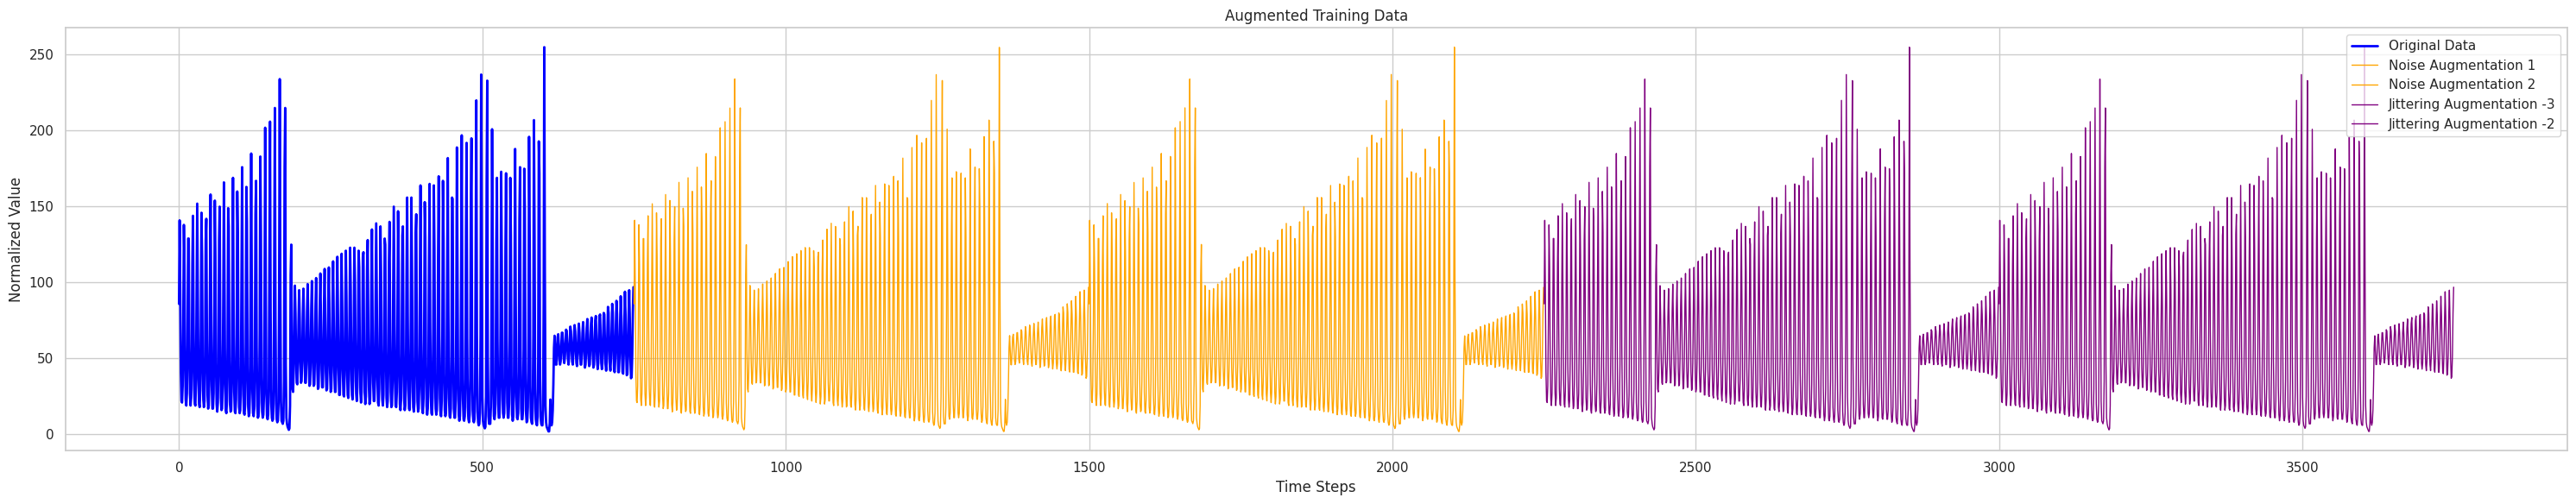

In [46]:
# Plot the train_dataset with different colors for each augmentation type
def plot_augmented_data(train_data, augmented_data, num_augmentations):
    plt.figure(figsize=(30, 6))

    # Plot the original data
    plt.plot(train_data, label="Original Data", color="blue", linewidth=2)

    # Plot the augmented data
    start_idx = len(train_data)
    for i in range(num_augmentations):
        end_idx = start_idx + len(train_data)
        if i < 2:
            label = f"Noise Augmentation {i + 1}"
            color = "orange"
        # elif i < 4:
        #     label = f"Drift Augmentation {i - 1}"
        #     color = "green"
        # elif i < 6:
        #     label = f"Time Warp Augmentation {i - 3}"
        #     color = "red"
        else:
            label = f"Jittering Augmentation {i - 5}"
            color = "purple"
        plt.plot(range(start_idx, end_idx), augmented_data[start_idx:end_idx], label=label, color=color, linewidth=1)
        start_idx = end_idx

    plt.xlabel("Time Steps")
    plt.ylabel("Normalized Value")
    plt.title("Augmented Training Data")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Call the function to plot the data
plot_augmented_data(train_data, train_augmented, num_augmentations=4)

### Training the Model

In [47]:
best_model = None

# Initialize a global DataFrame to store metrics for all trials
all_metrics_df = pd.DataFrame(columns=["trial_id", "epoch", "train_HuberLoss", "train_MSE", "train_MAE", "val_HuberLoss", "val_MSE", "val_MAE",
                                       "hidden_size", "num_layers", "learning_rate", "batch_size", "window_size"])

def objective(trial):
    global all_metrics_df  # Use the global DataFrame to store metrics

    # Suggest hyperparameters
    hidden_size = trial.suggest_int('hidden_size', 32, 256, step=32)
    num_layers = trial.suggest_int('num_layers', 1, 3)
    learning_rate = trial.suggest_float('lr', 1e-5, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [32, 64])
    window_size = trial.suggest_int('window_size', 5, 20, step=1)
    dropout = trial.suggest_float('dropout', 0.0, 0.4, step=0.1)

    # Update data loaders with the suggested batch size
    train_loader, train_X, train_y = prepare_dataloader(train_dataset, window_size, batch_size=batch_size)
    val_loader, val_X, val_y = prepare_dataloader(val_dataset, window_size, batch_size=batch_size)

    # Define the model
    model = RNN(
        input_size=1,  # Number of features in the input sequence
        hidden_size=hidden_size, # Number of features in the hidden state
        num_stacked_layers=num_layers, # Number of LSTM layers
        dropout=dropout  # Dropout rate
    ).to(device)

    # Train the model and get the final validation loss and metrics DataFrame
    trial_index = trial.number + 1  # Start from 1 for better readability in logs
    val_loss, metrics_df = train_model(
        model, train_loader, val_loader, attempt_index=trial_index, epochs=100, lr=learning_rate
    )

    # Add trial parameters to the metrics DataFrame
    metrics_df["hidden_size"] = hidden_size
    metrics_df["num_layers"] = num_layers
    metrics_df["learning_rate"] = learning_rate
    metrics_df["batch_size"] = batch_size
    metrics_df["window_size"] = window_size
    metrics_df["dropout"] = dropout  # Log the dropout value


    # Save the best model
    if trial.number == 0 or val_loss < study.best_value:
        torch.save(model.state_dict(), "best_model.pth")
        print(f"Best model saved with trial {trial.number}")
        best_model = model

        # Save the best hyperparameters
        with open("best_hyperparameters.json", "w") as f:
            json.dump({
                "hidden_size": hidden_size,
                "num_layers": num_layers,
                "learning_rate": learning_rate,
                "batch_size": batch_size,
                "window_size": window_size,
                "dropout": dropout
            }, f)

    # Append the metrics for this trial to the global DataFrame
    all_metrics_df = pd.concat([all_metrics_df, metrics_df], ignore_index=True)

    return val_loss  # Optuna will minimize this


# Create a study object
study = optuna.create_study(direction="minimize")  # Minimize validation loss

# Optimize the objective function
study.optimize(objective, n_trials=100)  # Run 100 trials

# Save the combined metrics DataFrame to a CSV file
all_metrics_df.to_csv("all_trials_metrics.csv", index=False)
print("All metrics saved to all_trials_metrics.csv")

# Print the best hyperparameters
print("Best hyperparameters:", study.best_params)

# Print the best validation loss
print("Best validation loss:", study.best_value)

# Load the best model
best_model = RNN(
    input_size=1,
    hidden_size=study.best_params['hidden_size'],
    num_stacked_layers=study.best_params['num_layers']
).to(device)
best_model.load_state_dict(torch.load("best_model.pth"))
print("Best model loaded.")

# Update train_loader and val_loader with the best hyperparameters
train_loader, train_X, train_y = prepare_dataloader(train_dataset, study.best_params['window_size'], batch_size=study.best_params['batch_size'])
val_loader, val_X, val_y = prepare_dataloader(val_dataset, study.best_params['window_size'], batch_size=study.best_params['batch_size'])
print("Data loaders updated with best hyperparameters.")

[I 2025-05-07 09:54:09,250] A new study created in memory with name: no-name-a8dfc78e-e87c-4d8a-b825-4985738a57d0


Trial: 1:   0%|          | 0/100 [00:00<?, ?epoch/s]

<ipython-input-47-43caeccd64b0>:63: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_metrics_df = pd.concat([all_metrics_df, metrics_df], ignore_index=True)
[I 2025-05-07 09:54:41,604] Trial 0 finished with value: 1.0956838130950928 and parameters: {'hidden_size': 256, 'num_layers': 1, 'lr': 0.0002783455931494174, 'batch_size': 64, 'window_size': 10, 'dropout': 0.1}. Best is trial 0 with value: 1.0956838130950928.


Early stopping triggered after 37 epochs.
Best model saved with trial 0


Trial: 2:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 09:54:53,785] Trial 1 finished with value: 0.4027431681752205 and parameters: {'hidden_size': 224, 'num_layers': 2, 'lr': 3.9787756173418895e-05, 'batch_size': 64, 'window_size': 7, 'dropout': 0.1}. Best is trial 1 with value: 0.4027431681752205.


Early stopping triggered after 27 epochs.
Best model saved with trial 1


Trial: 3:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 09:55:05,899] Trial 2 finished with value: 21.255794525146484 and parameters: {'hidden_size': 96, 'num_layers': 3, 'lr': 0.0031778165804381307, 'batch_size': 64, 'window_size': 12, 'dropout': 0.4}. Best is trial 1 with value: 0.4027431681752205.


Early stopping triggered after 26 epochs.


Trial: 4:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 09:55:34,203] Trial 3 finished with value: 0.41246433556079865 and parameters: {'hidden_size': 32, 'num_layers': 3, 'lr': 1.981325157899539e-05, 'batch_size': 64, 'window_size': 13, 'dropout': 0.4}. Best is trial 1 with value: 0.4027431681752205.


Early stopping triggered after 62 epochs.


Trial: 5:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 09:55:53,452] Trial 4 finished with value: 1.1515024900436401 and parameters: {'hidden_size': 32, 'num_layers': 2, 'lr': 0.004683591012792302, 'batch_size': 64, 'window_size': 13, 'dropout': 0.4}. Best is trial 1 with value: 0.4027431681752205.


Early stopping triggered after 40 epochs.


Trial: 6:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 09:56:19,962] Trial 5 finished with value: 2.8617556989192963 and parameters: {'hidden_size': 160, 'num_layers': 2, 'lr': 0.0007762577992785484, 'batch_size': 32, 'window_size': 8, 'dropout': 0.2}. Best is trial 1 with value: 0.4027431681752205.


Early stopping triggered after 31 epochs.


Trial: 7:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 09:56:32,485] Trial 6 finished with value: 0.699680931866169 and parameters: {'hidden_size': 192, 'num_layers': 3, 'lr': 7.460101125529638e-05, 'batch_size': 64, 'window_size': 6, 'dropout': 0.4}. Best is trial 1 with value: 0.4027431681752205.


Early stopping triggered after 26 epochs.


Trial: 8:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 09:56:57,020] Trial 7 finished with value: 0.5133162252604961 and parameters: {'hidden_size': 128, 'num_layers': 3, 'lr': 1.918487709440655e-05, 'batch_size': 32, 'window_size': 7, 'dropout': 0.2}. Best is trial 1 with value: 0.4027431681752205.


Early stopping triggered after 27 epochs.


Trial: 9:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 09:57:08,023] Trial 8 finished with value: 0.5924310386180878 and parameters: {'hidden_size': 96, 'num_layers': 1, 'lr': 1.7710187618901824e-05, 'batch_size': 64, 'window_size': 18, 'dropout': 0.1}. Best is trial 1 with value: 0.4027431681752205.


Early stopping triggered after 26 epochs.


Trial: 10:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 09:57:32,060] Trial 9 finished with value: 0.3801111653447151 and parameters: {'hidden_size': 192, 'num_layers': 1, 'lr': 1.467491960927335e-05, 'batch_size': 32, 'window_size': 18, 'dropout': 0.30000000000000004}. Best is trial 9 with value: 0.3801111653447151.


Early stopping triggered after 30 epochs.
Best model saved with trial 9


Trial: 11:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 09:58:18,266] Trial 10 finished with value: 1.297593042254448 and parameters: {'hidden_size': 256, 'num_layers': 1, 'lr': 0.00022077156749647045, 'batch_size': 32, 'window_size': 20, 'dropout': 0.30000000000000004}. Best is trial 9 with value: 0.3801111653447151.


Early stopping triggered after 58 epochs.


Trial: 12:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 09:58:40,446] Trial 11 finished with value: 3.337668240070343 and parameters: {'hidden_size': 192, 'num_layers': 2, 'lr': 6.883370546856384e-05, 'batch_size': 32, 'window_size': 16, 'dropout': 0.0}. Best is trial 9 with value: 0.3801111653447151.


Early stopping triggered after 26 epochs.


Trial: 13:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 09:59:02,169] Trial 12 finished with value: 3.9646343886852264 and parameters: {'hidden_size': 224, 'num_layers': 2, 'lr': 6.031266992838498e-05, 'batch_size': 32, 'window_size': 15, 'dropout': 0.2}. Best is trial 9 with value: 0.3801111653447151.


Early stopping triggered after 26 epochs.


Trial: 14:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 09:59:25,356] Trial 13 finished with value: 0.5261961854994297 and parameters: {'hidden_size': 192, 'num_layers': 1, 'lr': 1.10603728050225e-05, 'batch_size': 32, 'window_size': 5, 'dropout': 0.30000000000000004}. Best is trial 9 with value: 0.3801111653447151.


Early stopping triggered after 29 epochs.


Trial: 15:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 09:59:37,577] Trial 14 finished with value: 0.5493493676185608 and parameters: {'hidden_size': 224, 'num_layers': 1, 'lr': 3.507705841621801e-05, 'batch_size': 64, 'window_size': 10, 'dropout': 0.0}. Best is trial 9 with value: 0.3801111653447151.


Early stopping triggered after 29 epochs.


Trial: 16:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 09:59:59,785] Trial 15 finished with value: 5.376879513263702 and parameters: {'hidden_size': 160, 'num_layers': 2, 'lr': 0.00011747113359147439, 'batch_size': 32, 'window_size': 20, 'dropout': 0.1}. Best is trial 9 with value: 0.3801111653447151.


Early stopping triggered after 26 epochs.


Trial: 17:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:00:20,202] Trial 16 finished with value: 0.3415093570947647 and parameters: {'hidden_size': 224, 'num_layers': 1, 'lr': 1.1274731482901654e-05, 'batch_size': 64, 'window_size': 16, 'dropout': 0.30000000000000004}. Best is trial 16 with value: 0.3415093570947647.


Early stopping triggered after 48 epochs.
Best model saved with trial 16


Trial: 18:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:00:49,983] Trial 17 finished with value: 1.6399306654930115 and parameters: {'hidden_size': 128, 'num_layers': 1, 'lr': 0.000742573513835757, 'batch_size': 32, 'window_size': 16, 'dropout': 0.30000000000000004}. Best is trial 16 with value: 0.3415093570947647.


Early stopping triggered after 38 epochs.


Trial: 19:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:01:17,959] Trial 18 finished with value: 10.753291130065918 and parameters: {'hidden_size': 256, 'num_layers': 1, 'lr': 0.009185083305690945, 'batch_size': 64, 'window_size': 18, 'dropout': 0.30000000000000004}. Best is trial 16 with value: 0.3415093570947647.


Early stopping triggered after 64 epochs.


Trial: 20:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:01:50,395] Trial 19 finished with value: 0.36699361354112625 and parameters: {'hidden_size': 192, 'num_layers': 1, 'lr': 1.0267195786431293e-05, 'batch_size': 32, 'window_size': 18, 'dropout': 0.30000000000000004}. Best is trial 16 with value: 0.3415093570947647.


Early stopping triggered after 40 epochs.


Trial: 21:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:02:08,067] Trial 20 finished with value: 3.5456326603889465 and parameters: {'hidden_size': 224, 'num_layers': 1, 'lr': 0.0009871989570457847, 'batch_size': 64, 'window_size': 15, 'dropout': 0.30000000000000004}. Best is trial 16 with value: 0.3415093570947647.


Early stopping triggered after 41 epochs.


Trial: 22:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:02:33,666] Trial 21 finished with value: 0.358280997723341 and parameters: {'hidden_size': 192, 'num_layers': 1, 'lr': 1.0564720246057988e-05, 'batch_size': 32, 'window_size': 18, 'dropout': 0.30000000000000004}. Best is trial 16 with value: 0.3415093570947647.


Early stopping triggered after 32 epochs.


Trial: 23:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:02:53,944] Trial 22 finished with value: 0.5914621353149414 and parameters: {'hidden_size': 160, 'num_layers': 1, 'lr': 1.0868142440160625e-05, 'batch_size': 32, 'window_size': 17, 'dropout': 0.2}. Best is trial 16 with value: 0.3415093570947647.


Early stopping triggered after 26 epochs.


Trial: 24:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:03:15,817] Trial 23 finished with value: 0.39019073359668255 and parameters: {'hidden_size': 192, 'num_layers': 1, 'lr': 3.140340614612519e-05, 'batch_size': 32, 'window_size': 19, 'dropout': 0.30000000000000004}. Best is trial 16 with value: 0.3415093570947647.


Early stopping triggered after 27 epochs.


Trial: 25:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:03:37,625] Trial 24 finished with value: 0.42236272618174553 and parameters: {'hidden_size': 224, 'num_layers': 1, 'lr': 2.7087797361909592e-05, 'batch_size': 32, 'window_size': 15, 'dropout': 0.4}. Best is trial 16 with value: 0.3415093570947647.


Early stopping triggered after 27 epochs.


Trial: 26:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:04:10,733] Trial 25 finished with value: 1.0517370253801346 and parameters: {'hidden_size': 160, 'num_layers': 1, 'lr': 0.00013894754944576102, 'batch_size': 32, 'window_size': 17, 'dropout': 0.30000000000000004}. Best is trial 16 with value: 0.3415093570947647.


Early stopping triggered after 41 epochs.


Trial: 27:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:04:34,763] Trial 26 finished with value: 0.41635166853666306 and parameters: {'hidden_size': 256, 'num_layers': 2, 'lr': 1.0480664493727457e-05, 'batch_size': 32, 'window_size': 19, 'dropout': 0.2}. Best is trial 16 with value: 0.3415093570947647.


Early stopping triggered after 27 epochs.


Trial: 28:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:04:57,044] Trial 27 finished with value: 0.5535944029688835 and parameters: {'hidden_size': 128, 'num_layers': 1, 'lr': 4.8654289718892884e-05, 'batch_size': 32, 'window_size': 14, 'dropout': 0.2}. Best is trial 16 with value: 0.3415093570947647.


Early stopping triggered after 28 epochs.


Trial: 29:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:05:10,141] Trial 28 finished with value: 0.37064993381500244 and parameters: {'hidden_size': 192, 'num_layers': 2, 'lr': 2.419888734674339e-05, 'batch_size': 64, 'window_size': 17, 'dropout': 0.30000000000000004}. Best is trial 16 with value: 0.3415093570947647.


Early stopping triggered after 28 epochs.


Trial: 30:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:05:25,505] Trial 29 finished with value: 1.0750576555728912 and parameters: {'hidden_size': 224, 'num_layers': 1, 'lr': 0.00030319987081487586, 'batch_size': 64, 'window_size': 12, 'dropout': 0.4}. Best is trial 16 with value: 0.3415093570947647.


Early stopping triggered after 37 epochs.


Trial: 31:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:05:56,305] Trial 30 finished with value: 0.787239208817482 and parameters: {'hidden_size': 256, 'num_layers': 1, 'lr': 0.00013193358621597597, 'batch_size': 32, 'window_size': 19, 'dropout': 0.2}. Best is trial 16 with value: 0.3415093570947647.


Early stopping triggered after 39 epochs.


Trial: 32:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:06:08,200] Trial 31 finished with value: 0.657271683216095 and parameters: {'hidden_size': 192, 'num_layers': 2, 'lr': 1.9276987758033525e-05, 'batch_size': 64, 'window_size': 17, 'dropout': 0.30000000000000004}. Best is trial 16 with value: 0.3415093570947647.


Early stopping triggered after 26 epochs.


Trial: 33:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:06:19,627] Trial 32 finished with value: 0.5686798691749573 and parameters: {'hidden_size': 224, 'num_layers': 1, 'lr': 2.407468438425058e-05, 'batch_size': 64, 'window_size': 16, 'dropout': 0.30000000000000004}. Best is trial 16 with value: 0.3415093570947647.


Early stopping triggered after 27 epochs.


Trial: 34:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:06:34,620] Trial 33 finished with value: 0.3564019575715065 and parameters: {'hidden_size': 192, 'num_layers': 2, 'lr': 1.3255997603009369e-05, 'batch_size': 64, 'window_size': 18, 'dropout': 0.30000000000000004}. Best is trial 16 with value: 0.3415093570947647.


Early stopping triggered after 31 epochs.


Trial: 35:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:06:47,767] Trial 34 finished with value: 0.612690880894661 and parameters: {'hidden_size': 160, 'num_layers': 3, 'lr': 1.3914468787171397e-05, 'batch_size': 64, 'window_size': 20, 'dropout': 0.4}. Best is trial 16 with value: 0.3415093570947647.


Early stopping triggered after 26 epochs.


Trial: 36:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:06:59,439] Trial 35 finished with value: 0.42219672352075577 and parameters: {'hidden_size': 192, 'num_layers': 2, 'lr': 4.3638596099908534e-05, 'batch_size': 64, 'window_size': 14, 'dropout': 0.30000000000000004}. Best is trial 16 with value: 0.3415093570947647.


Early stopping triggered after 26 epochs.


Trial: 37:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:07:35,129] Trial 36 finished with value: 0.43459539115428925 and parameters: {'hidden_size': 96, 'num_layers': 1, 'lr': 1.0788809496867594e-05, 'batch_size': 64, 'window_size': 18, 'dropout': 0.4}. Best is trial 16 with value: 0.3415093570947647.


Early stopping triggered after 85 epochs.


Trial: 38:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:07:47,286] Trial 37 finished with value: 7.828819274902344 and parameters: {'hidden_size': 64, 'num_layers': 3, 'lr': 0.001366300961642056, 'batch_size': 64, 'window_size': 10, 'dropout': 0.4}. Best is trial 16 with value: 0.3415093570947647.


Early stopping triggered after 26 epochs.


Trial: 39:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:08:02,806] Trial 38 finished with value: 0.3661702275276184 and parameters: {'hidden_size': 160, 'num_layers': 2, 'lr': 1.4618946122724257e-05, 'batch_size': 64, 'window_size': 19, 'dropout': 0.30000000000000004}. Best is trial 16 with value: 0.3415093570947647.


Early stopping triggered after 33 epochs.


Trial: 40:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:08:21,974] Trial 39 finished with value: 0.4810190573334694 and parameters: {'hidden_size': 128, 'num_layers': 2, 'lr': 1.6709419130263054e-05, 'batch_size': 64, 'window_size': 19, 'dropout': 0.2}. Best is trial 16 with value: 0.3415093570947647.


Early stopping triggered after 44 epochs.


Trial: 41:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:08:33,759] Trial 40 finished with value: 0.8794218301773071 and parameters: {'hidden_size': 160, 'num_layers': 2, 'lr': 9.114772853924193e-05, 'batch_size': 64, 'window_size': 11, 'dropout': 0.1}. Best is trial 16 with value: 0.3415093570947647.


Early stopping triggered after 26 epochs.


Trial: 42:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:08:52,389] Trial 41 finished with value: 0.4286697208881378 and parameters: {'hidden_size': 192, 'num_layers': 2, 'lr': 1.4100968466217441e-05, 'batch_size': 64, 'window_size': 18, 'dropout': 0.30000000000000004}. Best is trial 16 with value: 0.3415093570947647.


Early stopping triggered after 40 epochs.


Trial: 43:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:09:05,780] Trial 42 finished with value: 0.4323708191514015 and parameters: {'hidden_size': 160, 'num_layers': 3, 'lr': 2.2423857507890943e-05, 'batch_size': 64, 'window_size': 19, 'dropout': 0.30000000000000004}. Best is trial 16 with value: 0.3415093570947647.


Early stopping triggered after 27 epochs.


Trial: 44:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:09:18,082] Trial 43 finished with value: 0.40927672386169434 and parameters: {'hidden_size': 224, 'num_layers': 2, 'lr': 3.346344311800566e-05, 'batch_size': 64, 'window_size': 20, 'dropout': 0.30000000000000004}. Best is trial 16 with value: 0.3415093570947647.


Early stopping triggered after 26 epochs.


Trial: 45:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:09:37,973] Trial 44 finished with value: 0.2057005539536476 and parameters: {'hidden_size': 192, 'num_layers': 1, 'lr': 1.4779355743073783e-05, 'batch_size': 64, 'window_size': 16, 'dropout': 0.4}. Best is trial 44 with value: 0.2057005539536476.


Early stopping triggered after 47 epochs.
Best model saved with trial 44


Trial: 46:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:09:52,089] Trial 45 finished with value: 0.35453614592552185 and parameters: {'hidden_size': 160, 'num_layers': 2, 'lr': 1.595484791297559e-05, 'batch_size': 64, 'window_size': 14, 'dropout': 0.4}. Best is trial 44 with value: 0.2057005539536476.


Early stopping triggered after 31 epochs.


Trial: 47:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:10:05,564] Trial 46 finished with value: 0.440912127494812 and parameters: {'hidden_size': 224, 'num_layers': 3, 'lr': 1.724340048353993e-05, 'batch_size': 64, 'window_size': 14, 'dropout': 0.4}. Best is trial 44 with value: 0.2057005539536476.


Early stopping triggered after 27 epochs.


Trial: 48:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:10:17,011] Trial 47 finished with value: 0.38338638097047806 and parameters: {'hidden_size': 192, 'num_layers': 1, 'lr': 5.3643814664995383e-05, 'batch_size': 64, 'window_size': 16, 'dropout': 0.4}. Best is trial 44 with value: 0.2057005539536476.


Early stopping triggered after 27 epochs.


Trial: 49:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:10:29,203] Trial 48 finished with value: 0.3764161840081215 and parameters: {'hidden_size': 160, 'num_layers': 2, 'lr': 4.137475538218138e-05, 'batch_size': 64, 'window_size': 13, 'dropout': 0.4}. Best is trial 44 with value: 0.2057005539536476.


Early stopping triggered after 27 epochs.


Trial: 50:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:10:41,721] Trial 49 finished with value: 0.3394523002207279 and parameters: {'hidden_size': 256, 'num_layers': 1, 'lr': 2.8968801633801184e-05, 'batch_size': 64, 'window_size': 15, 'dropout': 0.4}. Best is trial 44 with value: 0.2057005539536476.


Early stopping triggered after 29 epochs.


Trial: 51:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:10:54,619] Trial 50 finished with value: 0.4471515417098999 and parameters: {'hidden_size': 256, 'num_layers': 2, 'lr': 2.95680213384838e-05, 'batch_size': 64, 'window_size': 15, 'dropout': 0.4}. Best is trial 44 with value: 0.2057005539536476.


Early stopping triggered after 27 epochs.


Trial: 52:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:11:12,039] Trial 51 finished with value: 0.3331906385719776 and parameters: {'hidden_size': 256, 'num_layers': 1, 'lr': 1.4328693462161078e-05, 'batch_size': 64, 'window_size': 16, 'dropout': 0.4}. Best is trial 44 with value: 0.2057005539536476.


Early stopping triggered after 41 epochs.


Trial: 53:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:11:26,943] Trial 52 finished with value: 0.4113817401230335 and parameters: {'hidden_size': 256, 'num_layers': 1, 'lr': 1.833813015006401e-05, 'batch_size': 64, 'window_size': 14, 'dropout': 0.4}. Best is trial 44 with value: 0.2057005539536476.


Early stopping triggered after 33 epochs.


Trial: 54:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:11:45,375] Trial 53 finished with value: 0.3245273157954216 and parameters: {'hidden_size': 256, 'num_layers': 1, 'lr': 1.4390173388995449e-05, 'batch_size': 64, 'window_size': 16, 'dropout': 0.4}. Best is trial 44 with value: 0.2057005539536476.


Early stopping triggered after 42 epochs.


Trial: 55:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:11:58,289] Trial 54 finished with value: 0.35531456023454666 and parameters: {'hidden_size': 256, 'num_layers': 1, 'lr': 2.0362248273041553e-05, 'batch_size': 64, 'window_size': 16, 'dropout': 0.4}. Best is trial 44 with value: 0.2057005539536476.


Early stopping triggered after 30 epochs.


Trial: 56:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:12:22,668] Trial 55 finished with value: 1.2362276911735535 and parameters: {'hidden_size': 256, 'num_layers': 1, 'lr': 0.00043028812242881727, 'batch_size': 64, 'window_size': 13, 'dropout': 0.4}. Best is trial 44 with value: 0.2057005539536476.


Early stopping triggered after 57 epochs.


Trial: 57:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:12:34,321] Trial 56 finished with value: 0.36861641705036163 and parameters: {'hidden_size': 256, 'num_layers': 1, 'lr': 3.7277503973039796e-05, 'batch_size': 64, 'window_size': 15, 'dropout': 0.4}. Best is trial 44 with value: 0.2057005539536476.


Early stopping triggered after 27 epochs.


Trial: 58:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:12:52,444] Trial 57 finished with value: 4.926104307174683 and parameters: {'hidden_size': 224, 'num_layers': 1, 'lr': 0.00239044212534508, 'batch_size': 64, 'window_size': 16, 'dropout': 0.4}. Best is trial 44 with value: 0.2057005539536476.


Early stopping triggered after 43 epochs.


Trial: 59:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:13:03,654] Trial 58 finished with value: 0.48876167088747025 and parameters: {'hidden_size': 256, 'num_layers': 1, 'lr': 8.553531354411544e-05, 'batch_size': 64, 'window_size': 13, 'dropout': 0.4}. Best is trial 44 with value: 0.2057005539536476.


Early stopping triggered after 26 epochs.


Trial: 60:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:13:15,932] Trial 59 finished with value: 0.33598095178604126 and parameters: {'hidden_size': 224, 'num_layers': 1, 'lr': 2.5778596281064997e-05, 'batch_size': 64, 'window_size': 15, 'dropout': 0.4}. Best is trial 44 with value: 0.2057005539536476.


Early stopping triggered after 29 epochs.


Trial: 61:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:13:29,606] Trial 60 finished with value: 0.3481728062033653 and parameters: {'hidden_size': 224, 'num_layers': 1, 'lr': 2.151846114430282e-05, 'batch_size': 64, 'window_size': 17, 'dropout': 0.4}. Best is trial 44 with value: 0.2057005539536476.


Early stopping triggered after 32 epochs.


Trial: 62:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:13:42,076] Trial 61 finished with value: 0.3362724632024765 and parameters: {'hidden_size': 224, 'num_layers': 1, 'lr': 2.8374519726936336e-05, 'batch_size': 64, 'window_size': 17, 'dropout': 0.4}. Best is trial 44 with value: 0.2057005539536476.


Early stopping triggered after 29 epochs.


Trial: 63:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:13:55,536] Trial 62 finished with value: 0.2518441826105118 and parameters: {'hidden_size': 224, 'num_layers': 1, 'lr': 2.9735426283379898e-05, 'batch_size': 64, 'window_size': 15, 'dropout': 0.4}. Best is trial 44 with value: 0.2057005539536476.


Early stopping triggered after 31 epochs.


Trial: 64:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:14:06,747] Trial 63 finished with value: 0.35814694315195084 and parameters: {'hidden_size': 224, 'num_layers': 1, 'lr': 6.338476732110743e-05, 'batch_size': 64, 'window_size': 15, 'dropout': 0.4}. Best is trial 44 with value: 0.2057005539536476.


Early stopping triggered after 27 epochs.


Trial: 65:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:14:18,920] Trial 64 finished with value: 0.3719504177570343 and parameters: {'hidden_size': 256, 'num_layers': 1, 'lr': 2.8198952943240495e-05, 'batch_size': 64, 'window_size': 17, 'dropout': 0.4}. Best is trial 44 with value: 0.2057005539536476.


Early stopping triggered after 28 epochs.


Trial: 66:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:14:34,420] Trial 65 finished with value: 0.3457864932715893 and parameters: {'hidden_size': 224, 'num_layers': 1, 'lr': 3.4473372220117637e-05, 'batch_size': 64, 'window_size': 15, 'dropout': 0.4}. Best is trial 44 with value: 0.2057005539536476.


Early stopping triggered after 29 epochs.


Trial: 67:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:14:52,358] Trial 66 finished with value: 2.168154627084732 and parameters: {'hidden_size': 256, 'num_layers': 1, 'lr': 0.00017915826710509735, 'batch_size': 64, 'window_size': 16, 'dropout': 0.4}. Best is trial 44 with value: 0.2057005539536476.


Early stopping triggered after 42 epochs.


Trial: 68:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:15:03,929] Trial 67 finished with value: 0.47137559950351715 and parameters: {'hidden_size': 224, 'num_layers': 1, 'lr': 5.2526127237946075e-05, 'batch_size': 64, 'window_size': 17, 'dropout': 0.4}. Best is trial 44 with value: 0.2057005539536476.


Early stopping triggered after 27 epochs.


Trial: 69:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:15:16,458] Trial 68 finished with value: 0.3039664700627327 and parameters: {'hidden_size': 256, 'num_layers': 1, 'lr': 2.648949102680856e-05, 'batch_size': 64, 'window_size': 15, 'dropout': 0.4}. Best is trial 44 with value: 0.2057005539536476.


Early stopping triggered after 29 epochs.


Trial: 70:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:15:29,177] Trial 69 finished with value: 0.32465388625860214 and parameters: {'hidden_size': 224, 'num_layers': 1, 'lr': 2.4626591682372183e-05, 'batch_size': 64, 'window_size': 7, 'dropout': 0.4}. Best is trial 44 with value: 0.2057005539536476.


Early stopping triggered after 30 epochs.


Trial: 71:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:15:48,878] Trial 70 finished with value: 0.327069740742445 and parameters: {'hidden_size': 256, 'num_layers': 1, 'lr': 1.242467180524352e-05, 'batch_size': 64, 'window_size': 7, 'dropout': 0.4}. Best is trial 44 with value: 0.2057005539536476.


Early stopping triggered after 44 epochs.


Trial: 72:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:16:08,224] Trial 71 finished with value: 0.20461991429328918 and parameters: {'hidden_size': 256, 'num_layers': 1, 'lr': 1.2699312298035077e-05, 'batch_size': 64, 'window_size': 8, 'dropout': 0.4}. Best is trial 71 with value: 0.20461991429328918.


Early stopping triggered after 46 epochs.
Best model saved with trial 71


Trial: 73:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:16:28,658] Trial 72 finished with value: 0.35912610590457916 and parameters: {'hidden_size': 256, 'num_layers': 1, 'lr': 1.257349493736238e-05, 'batch_size': 64, 'window_size': 7, 'dropout': 0.4}. Best is trial 71 with value: 0.20461991429328918.


Early stopping triggered after 46 epochs.


Trial: 74:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:16:47,971] Trial 73 finished with value: 0.36477094888687134 and parameters: {'hidden_size': 256, 'num_layers': 1, 'lr': 1.2866813555752055e-05, 'batch_size': 64, 'window_size': 8, 'dropout': 0.4}. Best is trial 71 with value: 0.20461991429328918.


Early stopping triggered after 45 epochs.


Trial: 75:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:17:00,672] Trial 74 finished with value: 0.49751974642276764 and parameters: {'hidden_size': 256, 'num_layers': 1, 'lr': 1.703205793459809e-05, 'batch_size': 64, 'window_size': 5, 'dropout': 0.0}. Best is trial 71 with value: 0.20461991429328918.


Early stopping triggered after 30 epochs.


Trial: 76:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:17:12,606] Trial 75 finished with value: 0.5659670531749725 and parameters: {'hidden_size': 256, 'num_layers': 1, 'lr': 2.1959912826285423e-05, 'batch_size': 64, 'window_size': 6, 'dropout': 0.4}. Best is trial 71 with value: 0.20461991429328918.


Early stopping triggered after 28 epochs.


Trial: 77:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:17:31,804] Trial 76 finished with value: 0.4885456785559654 and parameters: {'hidden_size': 256, 'num_layers': 1, 'lr': 1.000347376582115e-05, 'batch_size': 64, 'window_size': 6, 'dropout': 0.4}. Best is trial 71 with value: 0.20461991429328918.


Early stopping triggered after 46 epochs.


Trial: 78:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:17:50,827] Trial 77 finished with value: 0.14028250612318516 and parameters: {'hidden_size': 256, 'num_layers': 1, 'lr': 1.4969018633324852e-05, 'batch_size': 64, 'window_size': 8, 'dropout': 0.4}. Best is trial 77 with value: 0.14028250612318516.


Early stopping triggered after 44 epochs.
Best model saved with trial 77


Trial: 79:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:18:08,388] Trial 78 finished with value: 0.4193418323993683 and parameters: {'hidden_size': 224, 'num_layers': 1, 'lr': 1.913403008403097e-05, 'batch_size': 64, 'window_size': 7, 'dropout': 0.4}. Best is trial 77 with value: 0.14028250612318516.


Early stopping triggered after 42 epochs.


Trial: 80:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:18:42,900] Trial 79 finished with value: 0.5396069511771202 and parameters: {'hidden_size': 32, 'num_layers': 1, 'lr': 1.2042927560160635e-05, 'batch_size': 64, 'window_size': 9, 'dropout': 0.4}. Best is trial 77 with value: 0.14028250612318516.


Early stopping triggered after 82 epochs.


Trial: 81:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:18:54,861] Trial 80 finished with value: 0.3075767830014229 and parameters: {'hidden_size': 256, 'num_layers': 1, 'lr': 4.4064181130335845e-05, 'batch_size': 64, 'window_size': 8, 'dropout': 0.4}. Best is trial 77 with value: 0.14028250612318516.


Early stopping triggered after 28 epochs.


Trial: 82:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:19:06,392] Trial 81 finished with value: 0.38440754264593124 and parameters: {'hidden_size': 256, 'num_layers': 1, 'lr': 4.2032431162816096e-05, 'batch_size': 64, 'window_size': 8, 'dropout': 0.4}. Best is trial 77 with value: 0.14028250612318516.


Early stopping triggered after 27 epochs.


Trial: 83:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:19:23,947] Trial 82 finished with value: 0.33798401802778244 and parameters: {'hidden_size': 256, 'num_layers': 1, 'lr': 1.626426677782464e-05, 'batch_size': 64, 'window_size': 7, 'dropout': 0.4}. Best is trial 77 with value: 0.14028250612318516.


Early stopping triggered after 42 epochs.


Trial: 84:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:19:36,868] Trial 83 finished with value: 0.3089004456996918 and parameters: {'hidden_size': 256, 'num_layers': 1, 'lr': 2.4585568689714158e-05, 'batch_size': 64, 'window_size': 9, 'dropout': 0.4}. Best is trial 77 with value: 0.14028250612318516.


Early stopping triggered after 30 epochs.


Trial: 85:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:19:54,568] Trial 84 finished with value: 0.2580902576446533 and parameters: {'hidden_size': 224, 'num_layers': 1, 'lr': 2.236138412974885e-05, 'batch_size': 64, 'window_size': 9, 'dropout': 0.4}. Best is trial 77 with value: 0.14028250612318516.


Early stopping triggered after 41 epochs.


Trial: 86:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:20:06,938] Trial 85 finished with value: 0.34626469761133194 and parameters: {'hidden_size': 256, 'num_layers': 1, 'lr': 3.3736927558538803e-05, 'batch_size': 64, 'window_size': 9, 'dropout': 0.4}. Best is trial 77 with value: 0.14028250612318516.


Early stopping triggered after 29 epochs.


Trial: 87:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:20:18,901] Trial 86 finished with value: 0.25907062366604805 and parameters: {'hidden_size': 224, 'num_layers': 1, 'lr': 4.7371489503983826e-05, 'batch_size': 64, 'window_size': 9, 'dropout': 0.4}. Best is trial 77 with value: 0.14028250612318516.


Early stopping triggered after 28 epochs.


Trial: 88:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:20:30,779] Trial 87 finished with value: 0.5057234987616539 and parameters: {'hidden_size': 224, 'num_layers': 1, 'lr': 4.7735372473015236e-05, 'batch_size': 64, 'window_size': 10, 'dropout': 0.4}. Best is trial 77 with value: 0.14028250612318516.


Early stopping triggered after 28 epochs.


Trial: 89:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:20:42,056] Trial 88 finished with value: 0.450939416885376 and parameters: {'hidden_size': 224, 'num_layers': 1, 'lr': 9.724985839604853e-05, 'batch_size': 64, 'window_size': 9, 'dropout': 0.4}. Best is trial 77 with value: 0.14028250612318516.


Early stopping triggered after 26 epochs.


Trial: 90:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:20:54,024] Trial 89 finished with value: 0.49601709097623825 and parameters: {'hidden_size': 192, 'num_layers': 1, 'lr': 6.309736018046906e-05, 'batch_size': 64, 'window_size': 10, 'dropout': 0.4}. Best is trial 77 with value: 0.14028250612318516.


Early stopping triggered after 27 epochs.


Trial: 91:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:21:05,905] Trial 90 finished with value: 0.2700309567153454 and parameters: {'hidden_size': 224, 'num_layers': 1, 'lr': 7.327114425473122e-05, 'batch_size': 64, 'window_size': 8, 'dropout': 0.4}. Best is trial 77 with value: 0.14028250612318516.


Early stopping triggered after 27 epochs.


Trial: 92:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:21:17,558] Trial 91 finished with value: 0.3300144597887993 and parameters: {'hidden_size': 224, 'num_layers': 1, 'lr': 5.668996247312886e-05, 'batch_size': 64, 'window_size': 8, 'dropout': 0.4}. Best is trial 77 with value: 0.14028250612318516.


Early stopping triggered after 27 epochs.


Trial: 93:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:21:29,959] Trial 92 finished with value: 0.3371572270989418 and parameters: {'hidden_size': 224, 'num_layers': 1, 'lr': 3.8978921784945335e-05, 'batch_size': 64, 'window_size': 9, 'dropout': 0.4}. Best is trial 77 with value: 0.14028250612318516.


Early stopping triggered after 29 epochs.


Trial: 94:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:21:41,585] Trial 93 finished with value: 0.4355136752128601 and parameters: {'hidden_size': 224, 'num_layers': 1, 'lr': 7.240621893556295e-05, 'batch_size': 64, 'window_size': 8, 'dropout': 0.4}. Best is trial 77 with value: 0.14028250612318516.


Early stopping triggered after 27 epochs.


Trial: 95:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:21:58,766] Trial 94 finished with value: 0.24584021791815758 and parameters: {'hidden_size': 192, 'num_layers': 1, 'lr': 2.334460572073198e-05, 'batch_size': 64, 'window_size': 9, 'dropout': 0.4}. Best is trial 77 with value: 0.14028250612318516.


Early stopping triggered after 41 epochs.


Trial: 96:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:22:18,555] Trial 95 finished with value: 0.4142657518386841 and parameters: {'hidden_size': 192, 'num_layers': 1, 'lr': 1.9999647782025485e-05, 'batch_size': 64, 'window_size': 11, 'dropout': 0.4}. Best is trial 77 with value: 0.14028250612318516.


Early stopping triggered after 41 epochs.


Trial: 97:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:22:52,639] Trial 96 finished with value: 2.4195065945386887 and parameters: {'hidden_size': 192, 'num_layers': 1, 'lr': 0.0004960141913025847, 'batch_size': 32, 'window_size': 11, 'dropout': 0.4}. Best is trial 77 with value: 0.14028250612318516.


Early stopping triggered after 42 epochs.


Trial: 98:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:23:09,151] Trial 97 finished with value: 0.2743666097521782 and parameters: {'hidden_size': 192, 'num_layers': 1, 'lr': 3.156177817670025e-05, 'batch_size': 64, 'window_size': 8, 'dropout': 0.30000000000000004}. Best is trial 77 with value: 0.14028250612318516.


Early stopping triggered after 38 epochs.


Trial: 99:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:23:22,348] Trial 98 finished with value: 0.6008511334657669 and parameters: {'hidden_size': 192, 'num_layers': 1, 'lr': 3.106289236527479e-05, 'batch_size': 64, 'window_size': 9, 'dropout': 0.30000000000000004}. Best is trial 77 with value: 0.14028250612318516.


Early stopping triggered after 31 epochs.


Trial: 100:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 10:23:40,018] Trial 99 finished with value: 0.4064404219388962 and parameters: {'hidden_size': 192, 'num_layers': 1, 'lr': 2.1968671964904456e-05, 'batch_size': 64, 'window_size': 10, 'dropout': 0.30000000000000004}. Best is trial 77 with value: 0.14028250612318516.


Early stopping triggered after 42 epochs.
All metrics saved to all_trials_metrics.csv
Best hyperparameters: {'hidden_size': 256, 'num_layers': 1, 'lr': 1.4969018633324852e-05, 'batch_size': 64, 'window_size': 8, 'dropout': 0.4}
Best validation loss: 0.14028250612318516
Best model loaded.
Data loaders updated with best hyperparameters.


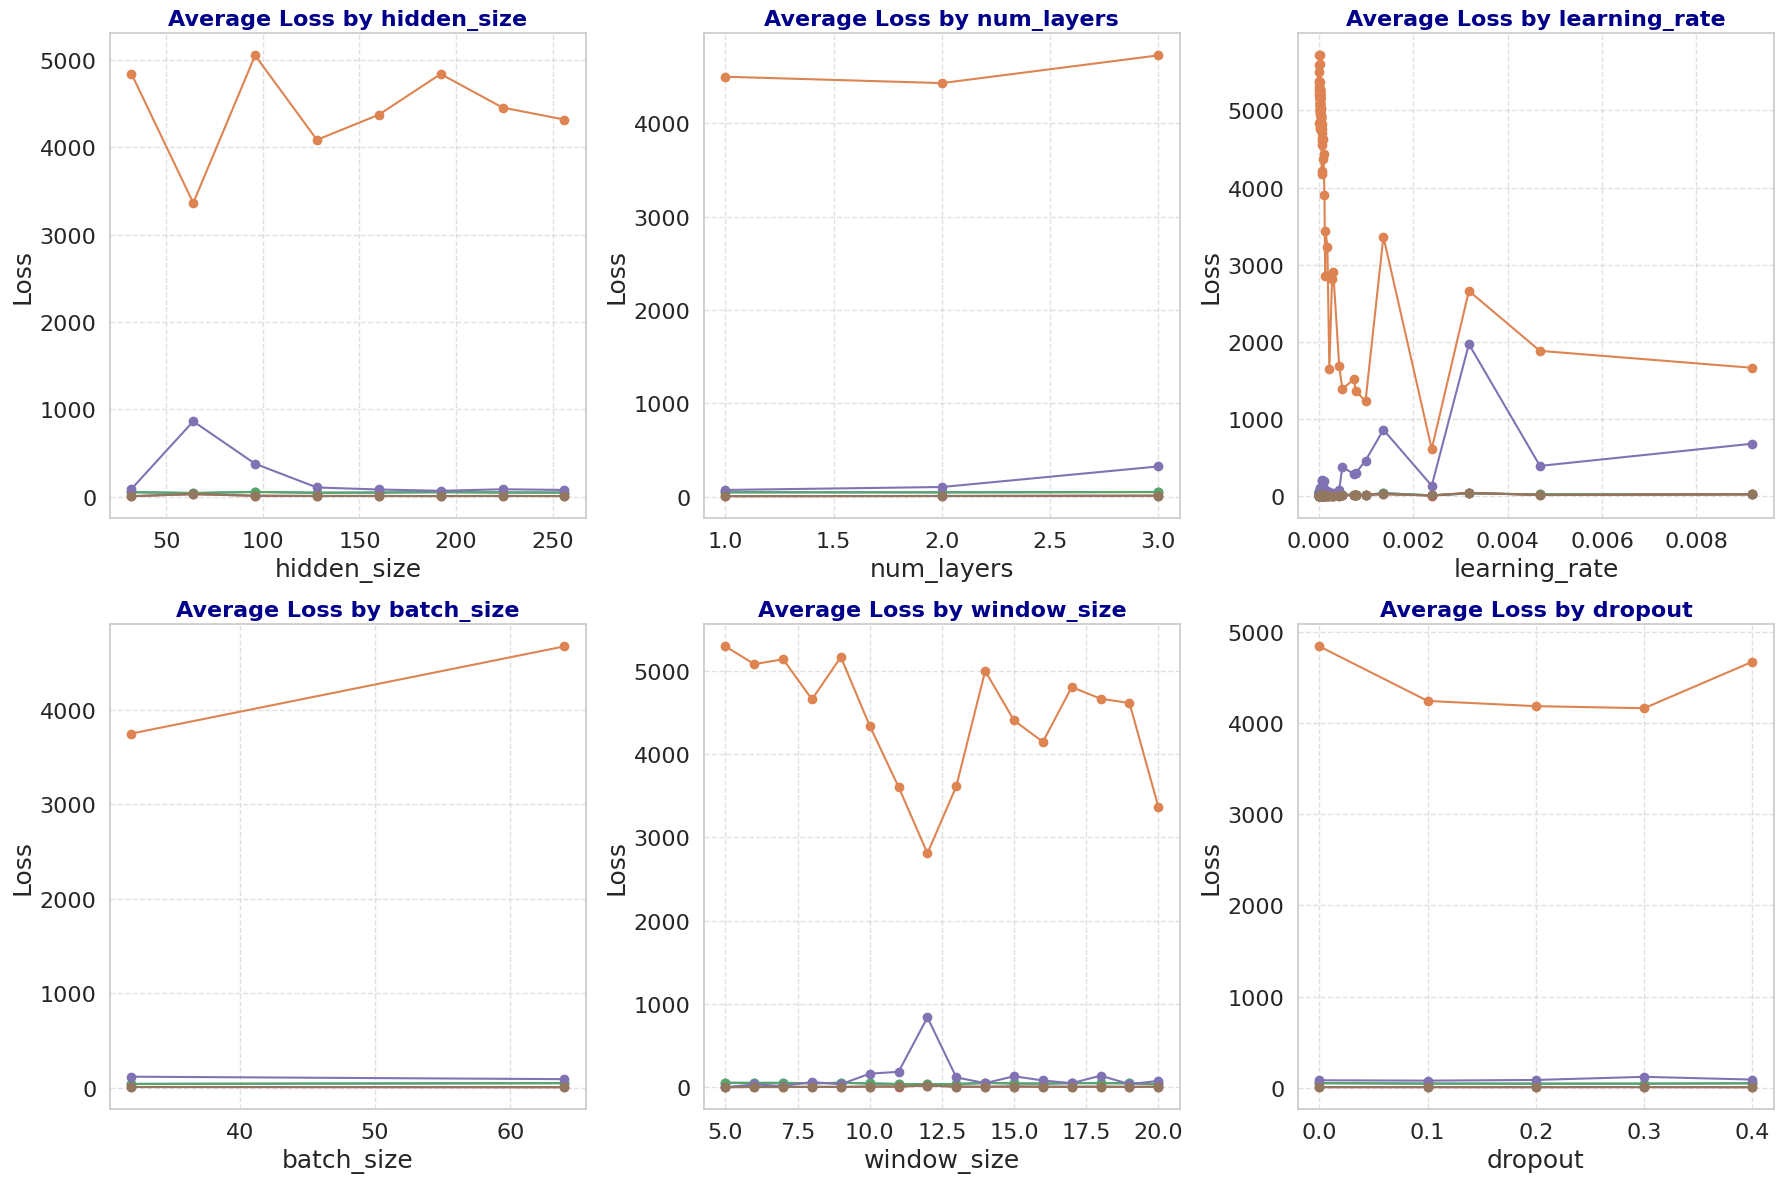

In [48]:
def plot_metrics_by_parameters(metrics_df, parameters, save_path="metrics_by_parameters.png"):
    """
    Create a single figure with subplots for each parameter, showing average losses.

    Args:
        metrics_df (pd.DataFrame): DataFrame containing trial metrics and parameters.
        parameters (list): List of parameters to plot (e.g., ['hidden_size', 'num_layers', 'dropout']).
    """
    # Mapping loss types to more readable names
    loss_type_mapping = {
        "train_HuberLoss": "Train Huber Loss",
        "train_MSE": "Train MSE",
        "train_MAE": "Train MAE",
        "val_HuberLoss": "Validation Huber Loss",
        "val_MSE": "Validation MSE",
        "val_MAE": "Validation MAE"
    }

    num_params = len(parameters)
    ncols = 3  # Number of columns
    nrows = (num_params + ncols - 1) // ncols  # Dynamically calculate rows based on parameters
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18, 6 * nrows), sharex=False)

    # Flatten axes for easier iteration
    axes = axes.flatten()

    # Plot each parameter
    for i, (ax, parameter) in enumerate(zip(axes, parameters)):
        grouped = metrics_df.groupby(parameter).mean()  # Group by the parameter and calculate averages
        for loss, readable_name in loss_type_mapping.items():
            if loss in grouped.columns:
                ax.plot(grouped.index, grouped[loss], label=readable_name, marker='o', linestyle='-', linewidth=1.5)

        # Customize each subplot
        ax.set_xlabel(parameter, fontsize=18)
        ax.set_ylabel("Loss", fontsize=18)
        ax.tick_params(axis='both', which='major', labelsize=16)
        ax.set_title(f"Average Loss by {parameter}", fontsize=16, weight='bold', color='darkblue')
        ax.grid(True, linestyle='--', alpha=0.6)

    # Remove unused subplots if parameters < nrows * ncols
    for j in range(len(parameters), len(axes)):
        if j == len(parameters):  # Use the first unused subplot for the legend
            handles, labels = ax.get_legend_handles_labels()
            axes[j].legend(
                handles, labels, loc="center", fontsize=16, title="Loss Type", title_fontsize=20, frameon=False
            )
            axes[j].set_axis_off()  # Turn off the axis for the legend plot
        else:
            fig.delaxes(axes[j])  # Remove any additional unused subplots

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.show()

# Example: Plot average losses for all parameters in one figure
parameters_to_plot = ["hidden_size", "num_layers", "learning_rate", "batch_size", "window_size", "dropout"]
plot_metrics_by_parameters(all_metrics_df, parameters_to_plot)

### Predict the next 200 data points recursively

<ipython-input-49-a4b982ca77d4>:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  init_window = torch.tensor(val_X[0], dtype=torch.float32).to(device)


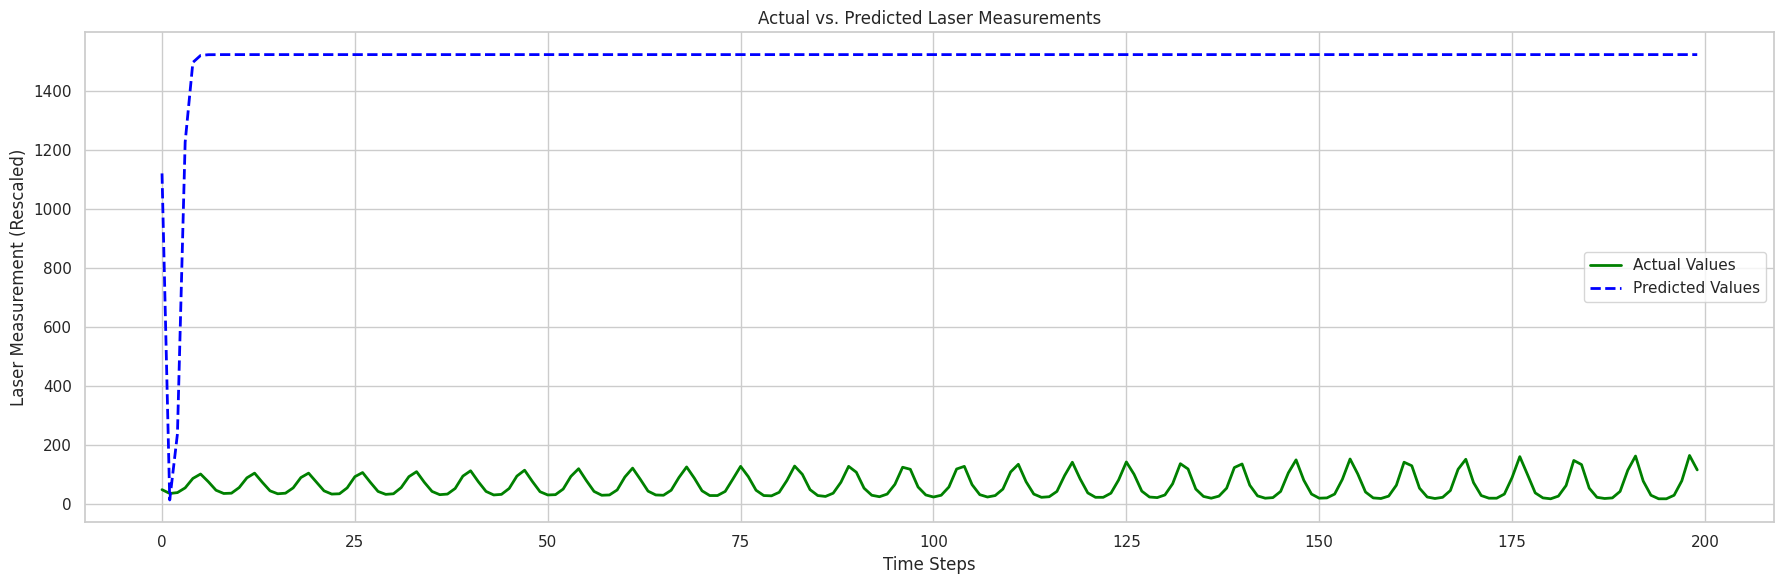

Metrics plot saved to actual_vs_predicted_plot.png


In [49]:
def predict_and_inverse_transform(model, init_window, scaler, steps=200):
    """
    Perform recursive forecasting using the trained model and convert predictions back to the original range.

    Args:
        model: The trained LSTM model.
        init_window: The initial sequence window (tensor) in normalized form.
        scaler: The MinMaxScaler used for normalization.
        steps: Number of forecasting steps.

    Returns:
        np.array: Forecasted values in the original range.
    """
    model.eval()
    preds = []
    current_seq = init_window.clone().to(device)  # Ensure the initial window is on the correct device

    with torch.no_grad():
        for step in range(steps):
            # Forward pass
            input = current_seq.unsqueeze(0).contiguous()  # Add batch dimension
            pred = model(input)  # shape: (1, seq_len, forecast_steps)

            # Extract the first predicted value
            pred_value = pred.item()  # Extract the first step of the forecast
            preds.append(pred_value)

            # Update the sequence by appending the prediction and removing the oldest value
            next_value = torch.tensor([[pred_value]], dtype=torch.float32, device=device)
            current_seq = torch.cat((current_seq[1:], next_value), dim=0)

    # Convert predictions to numpy array
    preds = np.array(preds).reshape(-1, 1)

    # Inverse transform the predictions to the original range
    preds_original = scaler.inverse_transform(preds)

    return preds_original

def plot_signals(predictions_rescaled, actual_values, save_path="actual_vs_predicted_plot.png"):
    """
    Plot training and validation metrics after training and compare predictions with actual values.
    """
    plt.figure(figsize=(18, 6))

    # Plot Actual vs Predicted Values
    plt.plot(actual_values, label="Actual Values", color="green", linewidth=2)
    plt.plot(predictions_rescaled, label="Predicted Values", color="blue", linestyle="--", linewidth=2)
    plt.xlabel("Time Steps")
    plt.ylabel("Laser Measurement (Rescaled)")
    plt.title("Actual vs. Predicted Laser Measurements")
    plt.legend()

    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.show()
    print(f"Metrics plot saved to {save_path}")

# Perform recursive forecasting to generate predictions
# Use the first sequence from the validation set as the initial window
init_window = torch.tensor(val_X[0], dtype=torch.float32).to(device)

# Predict and convert back to the original range
predicted_signal = predict_and_inverse_transform(best_model, init_window, scaler, steps=200)

# Compare with the actual values (also inverse transformed if needed)
actual_signal = scaler.inverse_transform(val_y[:len(predicted_signal)])

plot_signals(predicted_signal, actual_signal)

In [50]:
import torch.nn as nn

def evaluate_model_on_validation(best_model, val_loader):
    """
    Evaluate the best model on the validation dataset and calculate MSE and MAE using PyTorch loss functions.

    Args:
        best_model: The trained model.
        val_loader: The validation dataset (normalized).

    Returns:
        mse: Mean Squared Error.
        mae: Mean Absolute Error.
    """
    # Switch the model to evaluation mode
    best_model.eval()

    # Define PyTorch loss functions
    mse_criterion = nn.MSELoss()
    mae_criterion = nn.L1Loss()

    # Collect predictions and ground truth
    total_mse = 0.0
    total_mae = 0.0
    num_samples = 0

    with torch.no_grad():
        for batch in val_loader:
            x_batch, y_batch = batch[0].to(device), batch[1].to(device)
            output = best_model(x_batch)

            # Calculate losses
            mse = mse_criterion(output, y_batch).item()
            mae = mae_criterion(output, y_batch).item()

            # Accumulate losses
            total_mse += mse * x_batch.size(0)
            total_mae += mae * x_batch.size(0)
            num_samples += x_batch.size(0)

    # Calculate average losses
    avg_mse = total_mse / num_samples
    avg_mae = total_mae / num_samples

    print(f"Validation MSE: {avg_mse}")
    print(f"Validation MAE: {avg_mae}")

    return avg_mse, avg_mae

# Evaluate the best model
mse, mae = evaluate_model_on_validation(best_model, val_loader)

Validation MSE: 69.8747308273946
Validation MAE: 7.864071333703916


### Load the trained model

In [51]:
import json

def load_best_model():
    # Load the best hyperparameters
    with open("best_hyperparameters.json", "r") as f:
        best_params = json.load(f)

    # Recreate the model with the best hyperparameters
    best_model = LSTM(
        input_size=1,
        hidden_size=best_params["hidden_size"],
        num_stacked_layers=best_params["num_layers"]
    ).to(device)

    # Load the saved model weights
    best_model.load_state_dict(torch.load("best_model.pth"))
    best_model.eval()

    return best_model, best_params

best_model, best_params = load_best_model()
print("Best hyperparameters are:", best_params)

RuntimeError: Error(s) in loading state_dict for LSTM:
	Missing key(s) in state_dict: "lstm.weight_ih_l0", "lstm.weight_hh_l0", "lstm.bias_ih_l0", "lstm.bias_hh_l0". 
	Unexpected key(s) in state_dict: "rnn.weight_ih_l0", "rnn.weight_hh_l0", "rnn.bias_ih_l0", "rnn.bias_hh_l0". 